In [1]:
#### Necessary libraries ####
import numpy as np              # Numpy is the fundamental package for scientific computing in Python.
import netCDF4 as nc            # NetCDF is the data format of the meteorological data that we use.
import xarray as xr
import matplotlib.pyplot as plt # Matplotlib is a scientific plotting package.
import datetime                 # Datetime is a package to deal with dates.
import cartopy.crs as crs
import cartopy
from cmocean import cm
import os

from Functions import *

# The statement below enforces the plots to be put into this notebook, instead of in their own windows.
%matplotlib inline

In [2]:
################################################
####         DATA LOADING                   ####
################################################

## WRF-WVT ##
# Just csv file because of nature of simulations #

## WAM2layers ##
directory_str = "results WAM2layers/"
directory =  os.fsencode(directory_str)
n=0

for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith(".nc"): 
        print(filename)
        if n ==0:
            temp = xr.open_dataset(os.path.join(directory_str, filename))
            a_gridcell, lx, ly = get_grid_info(temp)
            srcs_wam2layers = temp["e_track"]* 1000 / a_gridcell[:, None]
            n+=1
        else:
            temp = xr.open_dataset(os.path.join(directory_str, filename))
            a_gridcell, lx, ly = get_grid_info(temp)
            srcs_wam2layers += temp["e_track"]* 1000 / a_gridcell[:, None]
            n+=1
        continue
    else:
        continue
        
dsall = xr.open_mfdataset('results WAM2layers/backtrack_*T00-00.nc', combine = 'nested', concat_dim='time')      
lat = dsall.latitude.values
lon = dsall.longitude.values
a_gridcell_new, l_ew_gridcell, l_mid_gridcell = get_grid_info_new(lat, lon)
E_track_totalmm = (dsall.e_track / a_gridcell_new) *1000 # mm
E_track_sumtimemm = E_track_totalmm.sum(dim='time') # mm

## University of Vigo ##
srcs_Vigo_e1_Stohl    = xr.open_dataset("results Uvigo/ERA5_Stohl_backwardreg.nc")["E_P"]
srcs_Vigo_e2_Sodemann = xr.open_dataset("results Uvigo/ERA5_sodemann_reg.nc")["E_P"]
    
## UTRACK - Arie STaal ##
directory_str = "results Utrack Arie Staal/moisture_tracking_intercomparsion/"
directory =  os.fsencode(directory_str)

dsall = xr.open_mfdataset('results Utrack Arie Staal/moisture_tracking_intercomparsion/*_mixing48h_dt025h_100p.nc', combine = 'nested', concat_dim='time')      
srcs_utrack_e1 = dsall["moisture_source"].sum("time")*1000.0
dsall = xr.open_mfdataset('results Utrack Arie Staal/moisture_tracking_intercomparsion/*_mixing24h_dt025h_100p.nc', combine = 'nested', concat_dim='time')      
srcs_utrack_e2 = dsall["moisture_source"].sum("time")*1000.0
dsall = xr.open_mfdataset('results Utrack Arie Staal/moisture_tracking_intercomparsion/*_mixing12h_dt025h_100p.nc', combine = 'nested', concat_dim='time')      
srcs_utrack_e3 = dsall["moisture_source"].sum("time")*1000.0
dsall = xr.open_mfdataset('results Utrack Arie Staal/moisture_tracking_intercomparsion/*_mixing24h_dt025h_1000p.nc', combine = 'nested', concat_dim='time')      
srcs_utrack_e4 = dsall["moisture_source"].sum("time")*1000.0
dsall = xr.open_mfdataset('results Utrack Arie Staal/moisture_tracking_intercomparsion/*_mixing24h_dt010h_100p.nc', combine = 'nested', concat_dim='time')      
srcs_utrack_e5 = dsall["moisture_source"].sum("time")*1000.0

## HAMSTER (Ghent) ##

# E1: Sodemann #
temp = xr.open_dataset("results UGhent HAMSTER/ugent_pakistan_bias_corrected/bias_corrected/ens1_sod08/bias_corrected_20220810120000_sod08.nc")
srcs_ghent_e1 = temp["E2P_BC"].mean("time")

for date in range(11,25):
    temp = xr.open_dataset("results UGhent HAMSTER/ugent_pakistan_bias_corrected/bias_corrected/ens1_sod08/bias_corrected_202208" + str(date) + "120000_sod08.nc")
    srcs_ghent_e1 += temp["E2P_BC"].mean("time")
    
# E2: FAS19 (Fremme + Sodemann, 2019) #
temp = xr.open_dataset("results UGhent HAMSTER/ugent_pakistan_bias_corrected/bias_corrected/ens2_fas19/bias_corrected_20220810120000_fas19.nc")
srcs_ghent_e2 = temp["E2P_BC"].mean("time")

for date in range(11,25):
    temp = xr.open_dataset("results UGhent HAMSTER/ugent_pakistan_bias_corrected/bias_corrected/ens2_fas19/bias_corrected_202208" + str(date) + "120000_fas19.nc")
    srcs_ghent_e2 += temp["E2P_BC"].mean("time")
    
# E3: FAS19 (Fremme + Sodemann, 2019) #
temp = xr.open_dataset("results UGhent HAMSTER/ugent_pakistan_bias_corrected/bias_corrected/ens3_rh20/bias_corrected_20220810120000_rh20.nc")
srcs_ghent_e3 = temp["E2P_BC"].mean("time")

for date in range(11,25):
    temp = xr.open_dataset("results UGhent HAMSTER/ugent_pakistan_bias_corrected/bias_corrected/ens3_rh20/bias_corrected_202208" + str(date) + "120000_rh20.nc")
    srcs_ghent_e3 += temp["E2P_BC"].mean("time")
    
# E4: 
temp = xr.open_dataset("results UGhent HAMSTER/ugent_pakistan_bias_corrected/bias_corrected/ens4_allabl/bias_corrected_20220810120000_allabl.nc")
srcs_ghent_e4 = temp["E2P_BC"].mean("time")

for date in range(11,25):
    temp = xr.open_dataset("results UGhent HAMSTER/ugent_pakistan_bias_corrected/bias_corrected/ens4_allabl/bias_corrected_202208" + str(date) + "120000_allabl.nc")
    srcs_ghent_e4 += temp["E2P_BC"].mean("time")

## TRACMASS Dipanjan Dey ## 
ds_TRACMASS = xr.open_dataset("results TRACMASS Dipanjan Dey/TRACMASS_diagnostics.nc") #Evaporative sources (and preicp?) mm/day
ds_pr_TRACMASS = xr.open_dataset("results TRACMASS Dipanjan Dey/PR_ERA5_TRACMASS.nc") #Precip ERA5 and TRACMASS Comparison
#convert to -180 to 180 lon
ds_TRACMASS.coords['lon'] = (ds_TRACMASS.coords['lon'] + 180) % 360 - 180
ds_TRACMASS = ds_TRACMASS.sortby(ds_TRACMASS.lon)
srcs_TRACMASS = ds_TRACMASS["E_TRACMASS"]*15
        
## FLEXPART-Watersip TatFanCheng ##
filename = "results FLEXPART_WaterSip_TatFanCheng/Pakistan_case_FLEXPART_WaterSip_TatFanCheng/WaterSip_Cb_20220810-20220824_Pakistan_box.nc"
ds_flexpart_watersip = xr.open_dataset(filename)
#convert to -180 to 180 lon
ds_flexpart_watersip.coords['lon'] = (ds_flexpart_watersip.coords['lon'] + 180) % 360 - 180
ds_flexpart_watersip = ds_flexpart_watersip.sortby(ds_TRACMASS.lon)
srcs_flexpart_watersip = ds_flexpart_watersip.sum("time")["Cb"]

## Flexpart Ru Xu ##
ds_flexpart_xu = xr.open_dataset("case_Ru_Xu_FLEXPART/submit/e_daily.nc")
srcs_flexpart_xu = ds_flexpart_xu["variable"].sum("time")


backtrack_2022-08-17T00-00.nc
backtrack_2022-08-16T00-00.nc
backtrack_2022-08-23T00-00.nc
backtrack_2022-08-22T00-00.nc
backtrack_2022-07-06T00-00.nc
backtrack_2022-07-07T00-00.nc
backtrack_2022-08-01T00-00.nc
backtrack_2022-07-25T00-00.nc
backtrack_2022-07-24T00-00.nc
backtrack_2022-07-11T00-00.nc
backtrack_2022-07-10T00-00.nc
backtrack_2022-07-22T00-00.nc
backtrack_2022-07-23T00-00.nc
backtrack_2022-08-07T00-00.nc
backtrack_2022-08-06T00-00.nc
backtrack_2022-07-28T00-00.nc
backtrack_2022-07-29T00-00.nc
backtrack_2022-07-16T00-00.nc
backtrack_2022-07-17T00-00.nc
backtrack_2022-08-10T00-00.nc
backtrack_2022-08-11T00-00.nc
backtrack_2022-07-01T00-00.nc
backtrack_2022-08-09T00-00.nc
backtrack_2022-08-08T00-00.nc
backtrack_2022-07-12T00-00.nc
backtrack_2022-07-13T00-00.nc
backtrack_2022-08-03T00-00.nc
backtrack_2022-08-02T00-00.nc
backtrack_2022-07-26T00-00.nc
backtrack_2022-07-27T00-00.nc
backtrack_2022-07-18T00-00.nc
backtrack_2022-07-19T00-00.nc
backtrack_2022-08-20T00-00.nc
backtrack_

In [ ]:
# Make sample figure (in this case of WAM2layers)
my_projection = crs.PlateCarree(central_longitude=0)

fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection=crs.PlateCarree())

srcs_wam2layers.plot(
        vmin=0,
        vmax=15,
        robust=False,
        cmap=cm.rain,
        cbar_kwargs=dict(fraction=0.05, shrink=0.5),
    )
srcs_wam2layers.plot.contour(ax=ax, levels=[0.1, 1], colors=["lightgrey", "grey"])
ax.set_title("Accumulated tracked moisture [mm]", loc="left")
ax.add_feature(cartopy.feature.COASTLINE, linewidth=0.8)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=.2)

ax.set_xticks(np.arange(-180, 181, 10), crs=my_projection)
ax.set_yticks(np.arange(-90, 91, 10), crs=my_projection)
ax.set_xlim(0, 140)
ax.set_ylim(-40, 50)
plt.savefig("Wam2layers_sources_Pakistan.png")


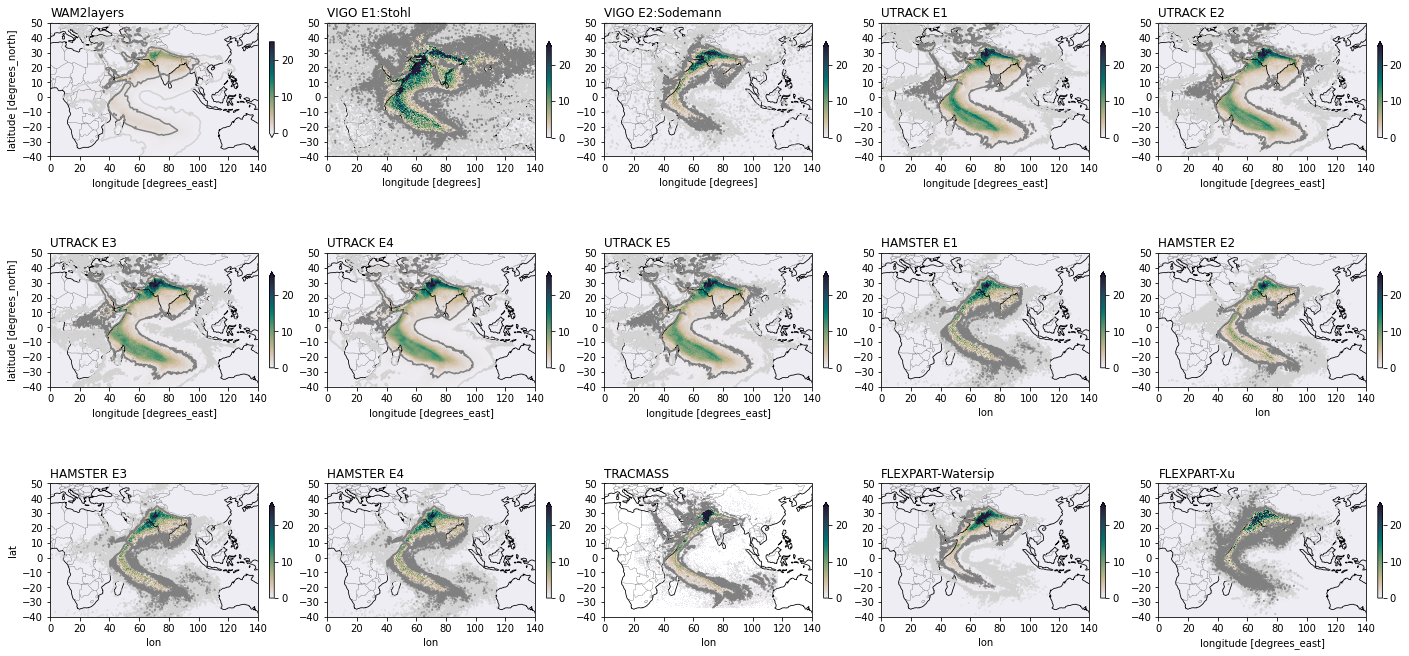

In [42]:
### MAKE PLOT OF DIFFERENT ENSEMBLE MEMBERS (not corrected for different sums) ###
my_projection = crs.PlateCarree(central_longitude=0)

# Make figure
fig, axs = plt.subplots(3, 5, figsize=(24, 12),subplot_kw={'projection': crs.PlateCarree()},sharey=False)

#Ensemble member 1: WAM2layers
srcs_wam2layers.plot(ax=axs[0,0],vmin=0,vmax=25,robust=False,cmap=cm.rain,
                     cbar_kwargs=dict(fraction=0.05, shrink=0.5,label=None),)
srcs_wam2layers.plot.contour(ax=axs[0,0], levels=[0.1, 1], colors=["lightgrey", "grey"])
axs[0,0].set_title("WAM2layers", loc="left")

#Ensemble member 2:
srcs_Vigo_e1_Stohl.plot(ax=axs[0,1],vmin=0,vmax=25,robust=False,cmap=cm.rain,
                        cbar_kwargs=dict(fraction=0.05, shrink=0.5,label=None),)
srcs_Vigo_e1_Stohl.plot.contour(ax=axs[0,1], levels=[0.1, 1], colors=["lightgrey", "grey"])
axs[0,1].set_title("VIGO E1:Stohl", loc="left")

#Ensemble member 3:
srcs_Vigo_e2_Sodemann.plot(ax=axs[0,2],vmin=0,vmax=25,robust=False,cmap=cm.rain,
        cbar_kwargs=dict(fraction=0.05, shrink=0.5,label=None),)
srcs_Vigo_e2_Sodemann.plot.contour(ax=axs[0,2], levels=[0.1, 1], colors=["lightgrey", "grey"])
axs[0,2].set_title("VIGO E2:Sodemann", loc="left")

#Ensemble member 4:
srcs_utrack_e1.plot(ax=axs[0,3],vmin=0,vmax=25, robust=False,cmap=cm.rain,
        cbar_kwargs=dict(fraction=0.05, shrink=0.5,label=None),)
srcs_utrack_e1.plot.contour(ax=axs[0,3], levels=[0.1, 1], colors=["lightgrey", "grey"])
axs[0,3].set_title("UTRACK E1", loc="left")

#Ensemble member 5:
srcs_utrack_e2.plot(ax=axs[0,4],vmin=0, vmax=25, robust=False,cmap=cm.rain,
        cbar_kwargs=dict(fraction=0.05, shrink=0.5,label=None),)
srcs_utrack_e2.plot.contour(ax=axs[0,4], levels=[0.1, 1], colors=["lightgrey", "grey"])
axs[0,4].set_title("UTRACK E2", loc="left")

#Ensemble member 6:
srcs_utrack_e3.plot(ax=axs[1,0],vmin=0,vmax=25, robust=False,cmap=cm.rain,
        cbar_kwargs=dict(fraction=0.05, shrink=0.5,label=None),)
srcs_utrack_e3.plot.contour(ax=axs[1,0], levels=[0.1, 1], colors=["lightgrey", "grey"])
axs[1,0].set_title("UTRACK E3", loc="left")

#Ensemble member 7:
srcs_utrack_e4.plot(ax=axs[1,1], vmin=0,vmax=25,robust=False,cmap=cm.rain,
        cbar_kwargs=dict(fraction=0.05, shrink=0.5,label=None),)
srcs_utrack_e4.plot.contour(ax=axs[1,1], levels=[0.1, 1], colors=["lightgrey", "grey"])
axs[1,1].set_title("UTRACK E4", loc="left")

#Ensemble member 8:
srcs_utrack_e5.plot(ax=axs[1,2], vmin=0, vmax=25, robust=False,cmap=cm.rain,
        cbar_kwargs=dict(fraction=0.05, shrink=0.5,label=None),)
srcs_utrack_e5.plot.contour(ax=axs[1,2], levels=[0.1, 1], colors=["lightgrey", "grey"])
axs[1,2].set_title("UTRACK E5", loc="left")

#Ensemble member 9:
srcs_ghent_e1.plot(ax=axs[1,3],vmin=0,vmax=25,robust=False,cmap=cm.rain,
        cbar_kwargs=dict(fraction=0.05, shrink=0.5,label=None), )
srcs_ghent_e1.plot.contour(ax=axs[1,3], levels=[0.1, 1], colors=["lightgrey", "grey"])
axs[1,3].set_title("HAMSTER E1", loc="left")

#Ensemble member 10:
srcs_ghent_e2.plot(ax=axs[1,4], vmin=0, vmax=25, robust=False,cmap=cm.rain,
        cbar_kwargs=dict(fraction=0.05, shrink=0.5,label=None),)
srcs_ghent_e2.plot.contour(ax=axs[1,4], levels=[0.1, 1], colors=["lightgrey", "grey"])
axs[1,4].set_title("HAMSTER E2", loc="left")

#Ensemble member 11:
srcs_ghent_e3.plot(ax=axs[2,0], vmin=0, vmax=25, robust=False, cmap=cm.rain,
        cbar_kwargs=dict(fraction=0.05, shrink=0.5,label=None),)
srcs_ghent_e3.plot.contour(ax=axs[2,0], levels=[0.1, 1], colors=["lightgrey", "grey"])
axs[2,0].set_title("HAMSTER E3", loc="left")

#Ensemble member 12:
srcs_ghent_e4.plot(ax=axs[2,1], vmin=0, vmax=25, robust=False, cmap=cm.rain,
        cbar_kwargs=dict(fraction=0.05, shrink=0.5,label=None),)
srcs_ghent_e4.plot.contour(ax=axs[2,1], levels=[0.1, 1], colors=["lightgrey", "grey"])
axs[2,1].set_title("HAMSTER E4", loc="left")

#Ensemble member 13:
srcs_TRACMASS.plot(ax=axs[2,2], vmin=0, vmax=25, robust=False, cmap=cm.rain,
        cbar_kwargs=dict(fraction=0.05, shrink=0.5,label=None),
    )
srcs_TRACMASS.plot.contour(ax=axs[2,2], levels=[0.1, 1], colors=["lightgrey", "grey"])
axs[2,2].set_title("TRACMASS", loc="left")

#Ensemble member 14:
srcs_flexpart_watersip.plot(ax=axs[2,3], vmin=0, vmax=25, robust=False, cmap=cm.rain,
        cbar_kwargs=dict(fraction=0.05, shrink=0.5,label=None),
    )
srcs_flexpart_watersip.plot.contour(ax=axs[2,3], levels=[0.1, 1], colors=["lightgrey", "grey"])
axs[2,3].set_title("FLEXPART-Watersip", loc="left")

#Ensemble member 15:
srcs_flexpart_xu.plot(ax=axs[2,4], vmin=0, vmax=25, robust=False, cmap=cm.rain,
        cbar_kwargs=dict(fraction=0.05, shrink=0.5,label=None),)
srcs_flexpart_xu.plot.contour(ax=axs[2,4], levels=[0.1, 1], colors=["lightgrey", "grey"])
axs[2,4].set_title("FLEXPART-Xu", loc="left")

#GENERAL Features which should appear for each subplot
for i in range(3):
    for j in range(5):
        axs[i,j].add_feature(cartopy.feature.COASTLINE, linewidth=0.8)
        axs[i,j].add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=.2)

        axs[i,j].set_xticks(np.arange(-180, 181, 20), crs=my_projection)
        axs[i,j].set_yticks(np.arange(-90, 91, 10), crs=my_projection)
        axs[i,j].set_xlim(0, 140)
        axs[i,j].set_ylim(-40, 50)
        
        #Dismiss label of y-axis, except for left most column
        if(j > 0):
            axs[i,j].set_ylabel("")

fig.savefig("MoistureSources_NotCorrected_all.png",dpi=300)

In [ ]:
### MAKE PLOT OF DIFFERENT ENSEMBLE MEMBERS (not corrected for different sums) ###
### SAME AS ABOVE BUT RANDOMIZED ORDER ###
my_projection = crs.PlateCarree(central_longitude=0)

# Make figure
fig = plt.figure(figsize=(24, 10))

#Ensemble member 11:
ax11 = fig.add_subplot(3,5,1, projection=crs.PlateCarree())

srcs_ghent_e3.plot(
        vmin=0,
        vmax=25,
        robust=False,
        cmap=cm.rain,
        cbar_kwargs=dict(fraction=0.05, shrink=0.5,label=None),
    )
srcs_ghent_e3.plot.contour(ax=ax11, levels=[0.1, 1], colors=["lightgrey", "grey"])
#ax11.set_title("HAMSTER E3", loc="left")
ax11.set_title("E1", loc="left")
ax11.add_feature(cartopy.feature.COASTLINE, linewidth=0.8)
ax11.add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=.2)

ax11.set_xticks(np.arange(-180, 181, 20), crs=my_projection)
ax11.set_yticks(np.arange(-90, 91, 10), crs=my_projection)
ax11.set_xlim(0, 140)
ax11.set_ylim(-40, 50)
ax11.set_ylabel("lat ($^\circ$N)")
ax11.set_xlabel("lon ($^\circ$E)")

#Ensemble member 6:
ax6 = fig.add_subplot(3,5,2, projection=crs.PlateCarree())

srcs_utrack_e3.plot(
        vmin=0,
        vmax=25,
        robust=False,
        cmap=cm.rain,
        cbar_kwargs=dict(fraction=0.05, shrink=0.5,label=None),
    )
srcs_utrack_e3.plot.contour(ax=ax6, levels=[0.1, 1], colors=["lightgrey", "grey"])
#ax6.set_title("UTRACK E3", loc="left")
ax6.set_title("E2", loc="left")
ax6.add_feature(cartopy.feature.COASTLINE, linewidth=0.8)
ax6.add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=.2)

ax6.set_xticks(np.arange(-180, 181, 20), crs=my_projection)
ax6.set_yticks(np.arange(-90, 91, 10), crs=my_projection)
ax6.set_xlim(0, 140)
ax6.set_ylim(-40, 50)
ax6.set_ylabel("")
ax6.set_xlabel("lon ($^\circ$E)")

#Ensemble member 1: WAM2layers
ax = fig.add_subplot(3,5,3, projection=crs.PlateCarree())

srcs_wam2layers.plot(
        vmin=0,
        vmax=25,
        robust=False,
        cmap=cm.rain,
        cbar_kwargs=dict(fraction=0.05, shrink=0.5,label=None),
    )
srcs_wam2layers.plot.contour(ax=ax, levels=[0.1, 1], colors=["lightgrey", "grey"])
#ax.set_title("WAM2layers", loc="left")
ax.set_title("E3", loc="left")
ax.add_feature(cartopy.feature.COASTLINE, linewidth=0.8)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=.2)

ax.set_xticks(np.arange(-180, 181, 20), crs=my_projection)
ax.set_yticks(np.arange(-90, 91, 10), crs=my_projection)
ax.set_xlim(0, 140)
ax.set_ylim(-40, 50)
ax.set_ylabel("")
ax.set_xlabel("lon ($^\circ$E)")

#Ensemble member 2:
ax2 = fig.add_subplot(3,5,4, projection=crs.PlateCarree())

srcs_Vigo_e1_Stohl.plot(
        vmin=0,
        vmax=25,
        robust=False,
        cmap=cm.rain,
        cbar_kwargs=dict(fraction=0.05, shrink=0.5,label=None),
    )
srcs_Vigo_e1_Stohl.plot.contour(ax=ax2, levels=[0.1, 1], colors=["lightgrey", "grey"])
#ax2.set_title("VIGO E1:Stohl", loc="left")
ax2.set_title("E4", loc="left")
ax2.add_feature(cartopy.feature.COASTLINE, linewidth=0.8)
ax2.add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=.2)

ax2.set_xticks(np.arange(-180, 181, 20), crs=my_projection)
ax2.set_yticks(np.arange(-90, 91, 10), crs=my_projection)
ax2.set_xlim(0, 140)
ax2.set_ylim(-40, 50)
ax2.set_ylabel("")
ax2.set_xlabel("lon ($^\circ$E)")

#Ensemble member 3:
ax3 = fig.add_subplot(3,5,5, projection=crs.PlateCarree())

srcs_Vigo_e2_Sodemann.plot(
        vmin=0,
        vmax=25,
        robust=False,
        cmap=cm.rain,
        cbar_kwargs=dict(fraction=0.05, shrink=0.5,label=None),
    )
srcs_Vigo_e2_Sodemann.plot.contour(ax=ax3, levels=[0.1, 1], colors=["lightgrey", "grey"])
#ax3.set_title("VIGO E2:Sodemann", loc="left")
ax3.set_title("E5", loc="left")
ax3.add_feature(cartopy.feature.COASTLINE, linewidth=0.8)
ax3.add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=.2)

ax3.set_xticks(np.arange(-180, 181, 20), crs=my_projection)
ax3.set_yticks(np.arange(-90, 91, 10), crs=my_projection)
ax3.set_xlim(0, 140)
ax3.set_ylim(-40, 50)
ax3.set_ylabel("")
ax3.set_xlabel("lon ($^\circ$E)")


#Ensemble member 5:
ax5 = fig.add_subplot(3,5,6, projection=crs.PlateCarree())

srcs_utrack_e2.plot(
        vmin=0,
        vmax=25,
        robust=False,
        cmap=cm.rain,
        cbar_kwargs=dict(fraction=0.05, shrink=0.5,label=None),
    )
srcs_utrack_e2.plot.contour(ax=ax5, levels=[0.1, 1], colors=["lightgrey", "grey"])
#ax5.set_title("UTRACK E2", loc="left")
ax5.set_title("E6", loc="left")
ax5.add_feature(cartopy.feature.COASTLINE, linewidth=0.8)
ax5.add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=.2)

ax5.set_xticks(np.arange(-180, 181, 20), crs=my_projection)
ax5.set_yticks(np.arange(-90, 91, 10), crs=my_projection)
ax5.set_xlim(0, 140)
ax5.set_ylim(-40, 50)
#ax5.set_ylabel("")
ax5.set_ylabel("lat ($^\circ$N)")
ax5.set_xlabel("lon ($^\circ$E)")

#Ensemble member 4:
ax4 = fig.add_subplot(3,5,7, projection=crs.PlateCarree())

srcs_utrack_e1.plot(
        vmin=0,
        vmax=25,
        robust=False,
        cmap=cm.rain,
        cbar_kwargs=dict(fraction=0.05, shrink=0.5,label=None),
    )
srcs_utrack_e1.plot.contour(ax=ax4, levels=[0.1, 1], colors=["lightgrey", "grey"])
#ax4.set_title("UTRACK E1", loc="left")
ax4.set_title("E7", loc="left")
ax4.add_feature(cartopy.feature.COASTLINE, linewidth=0.8)
ax4.add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=.2)

ax4.set_xticks(np.arange(-180, 181, 20), crs=my_projection)
ax4.set_yticks(np.arange(-90, 91, 10), crs=my_projection)
ax4.set_xlim(0, 140)
ax4.set_ylim(-40, 50)
ax4.set_ylabel("")
ax4.set_xlabel("lon ($^\circ$E)")

#Ensemble member 8
ax8 = fig.add_subplot(3,5,8, projection=crs.PlateCarree())

srcs_utrack_e5.plot(
        vmin=0,
        vmax=25,
        robust=False,
        cmap=cm.rain,
        cbar_kwargs=dict(fraction=0.05, shrink=0.5,label=None),
    )
srcs_utrack_e5.plot.contour(ax=ax8, levels=[0.1, 1], colors=["lightgrey", "grey"])
#ax8.set_title("UTRACK E5", loc="left")
ax8.set_title("E8", loc="left")
ax8.add_feature(cartopy.feature.COASTLINE, linewidth=0.8)
ax8.add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=.2)

ax8.set_xticks(np.arange(-180, 181, 20), crs=my_projection)
ax8.set_yticks(np.arange(-90, 91, 10), crs=my_projection)
ax8.set_xlim(0, 140)
ax8.set_ylim(-40, 50)
ax8.set_ylabel("")
ax8.set_xlabel("lon ($^\circ$E)")

#Ensemble member 15:
ax15 = fig.add_subplot(3,5,9, projection=crs.PlateCarree())
srcs_flexpart_xu.plot(
        vmin=0,
        vmax=25,
        robust=False,
        cmap=cm.rain,
        cbar_kwargs=dict(fraction=0.05, shrink=0.5,label=None),
    )

srcs_flexpart_xu.plot.contour(ax=ax15, levels=[0.1, 1], colors=["lightgrey", "grey"])
#ax15.set_title("FLEXPART-Xu", loc="left")
ax15.set_title("E9", loc="left")
ax15.add_feature(cartopy.feature.COASTLINE, linewidth=0.8)
ax15.add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=.2)

ax15.set_xticks(np.arange(-180, 181, 20), crs=my_projection)
ax15.set_yticks(np.arange(-90, 91, 10), crs=my_projection)
ax15.set_xlim(0, 140)
ax15.set_ylim(-40, 50)
ax15.set_ylabel("")
ax15.set_xlabel("lon ($^\circ$E)")

#Ensemble member 10:
ax10 = fig.add_subplot(3,5,10, projection=crs.PlateCarree())

srcs_ghent_e2.plot(
        vmin=0,
        vmax=25,
        robust=False,
        cmap=cm.rain,
        cbar_kwargs=dict(fraction=0.05, shrink=0.5,label=None),
    )
srcs_ghent_e2.plot.contour(ax=ax10, levels=[0.1, 1], colors=["lightgrey", "grey"])
#ax10.set_title("HAMSTER E2", loc="left")
ax10.set_title("E10", loc="left")
ax10.add_feature(cartopy.feature.COASTLINE, linewidth=0.8)
ax10.add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=.2)

ax10.set_xticks(np.arange(-180, 181, 20), crs=my_projection)
ax10.set_yticks(np.arange(-90, 91, 10), crs=my_projection)
ax10.set_xlim(0, 140)
ax10.set_ylim(-40, 50)
ax10.set_ylabel("")
ax10.set_xlabel("lon ($^\circ$E)")

#Ensemble member 12:
ax12 = fig.add_subplot(3,5,11, projection=crs.PlateCarree())

srcs_ghent_e4.plot(
        vmin=0,
        vmax=25,
        robust=False,
        cmap=cm.rain,
        cbar_kwargs=dict(fraction=0.05, shrink=0.5,label=None),
    )
srcs_ghent_e4.plot.contour(ax=ax12, levels=[0.1, 1], colors=["lightgrey", "grey"])
#ax12.set_title("HAMSTER E4", loc="left")
ax12.set_title("E11", loc="left")
ax12.add_feature(cartopy.feature.COASTLINE, linewidth=0.8)
ax12.add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=.2)

ax12.set_xticks(np.arange(-180, 181, 20), crs=my_projection)
ax12.set_yticks(np.arange(-90, 91, 10), crs=my_projection)
ax12.set_xlim(0, 140)
ax12.set_ylim(-40, 50)
#ax12.set_ylabel("")
ax12.set_ylabel("lat ($^\circ$N)")
ax12.set_xlabel("lon ($^\circ$E)")

#Ensemble member 13:
ax13 = fig.add_subplot(3,5,12, projection=crs.PlateCarree())
srcs_TRACMASS.plot(
        vmin=0,
        vmax=25,
        robust=False,
        cmap=cm.rain,
        cbar_kwargs=dict(fraction=0.05, shrink=0.5,label=None),
    )

srcs_TRACMASS.plot.contour(ax=ax13, levels=[0.1, 1], colors=["lightgrey", "grey"])
#ax13.set_title("TRACMASS", loc="left")
ax13.set_title("E12", loc="left")
ax13.add_feature(cartopy.feature.COASTLINE, linewidth=0.8)
ax13.add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=.2)

ax13.set_xticks(np.arange(-180, 181, 20), crs=my_projection)
ax13.set_yticks(np.arange(-90, 91, 10), crs=my_projection)
ax13.set_xlim(0, 140)
ax13.set_ylim(-40, 50)
ax13.set_ylabel("")
ax13.set_xlabel("lon ($^\circ$E)")

#Ensemble member 9:
ax9 = fig.add_subplot(3,5,13, projection=crs.PlateCarree())

srcs_ghent_e1.plot(
        vmin=0,
        vmax=25,
        robust=False,
        cmap=cm.rain,
        cbar_kwargs=dict(fraction=0.05, shrink=0.5,label=None),
    )
srcs_ghent_e1.plot.contour(ax=ax9, levels=[0.1, 1], colors=["lightgrey", "grey"])
#ax9.set_title("HAMSTER E1", loc="left")
ax9.set_title("E13", loc="left")
ax9.add_feature(cartopy.feature.COASTLINE, linewidth=0.8)
ax9.add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=.2)

ax9.set_xticks(np.arange(-180, 181, 20), crs=my_projection)
ax9.set_yticks(np.arange(-90, 91, 10), crs=my_projection)
ax9.set_xlim(0, 140)
ax9.set_ylim(-40, 50)
ax9.set_ylabel("")
ax9.set_xlabel("lon ($^\circ$E)")

#Ensemble member 14:
ax14 = fig.add_subplot(3,5,14, projection=crs.PlateCarree())
srcs_flexpart_watersip.plot(
        vmin=0,
        vmax=25,
        robust=False,
        cmap=cm.rain,
        cbar_kwargs=dict(fraction=0.05, shrink=0.5,label=None),
    )

srcs_flexpart_watersip.plot.contour(ax=ax14, levels=[0.1, 1], colors=["lightgrey", "grey"])
#ax14.set_title("FLEXPART-Watersip", loc="left")
ax14.set_title("E14", loc="left")
ax14.add_feature(cartopy.feature.COASTLINE, linewidth=0.8)
ax14.add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=.2)

ax14.set_xticks(np.arange(-180, 181, 20), crs=my_projection)
ax14.set_yticks(np.arange(-90, 91, 10), crs=my_projection)
ax14.set_xlim(0, 140)
ax14.set_ylim(-40, 50)
ax14.set_ylabel("")
ax14.set_xlabel("lon ($^\circ$E)")

#Ensemble member 7:
ax7 = fig.add_subplot(3,5,15, projection=crs.PlateCarree())

srcs_utrack_e4.plot(
        vmin=0,
        vmax=25,
        robust=False,
        cmap=cm.rain,
        cbar_kwargs=dict(fraction=0.05, shrink=0.5,label=None),
    )
srcs_utrack_e4.plot.contour(ax=ax7, levels=[0.1, 1], colors=["lightgrey", "grey"])
#ax7.set_title("UTRACK E4", loc="left")
ax7.set_title("E15", loc="left")
ax7.add_feature(cartopy.feature.COASTLINE, linewidth=0.8)
ax7.add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=.2)

ax7.set_xticks(np.arange(-180, 181, 20), crs=my_projection)
ax7.set_yticks(np.arange(-90, 91, 10), crs=my_projection)
ax7.set_xlim(0, 140)
ax7.set_ylim(-40, 50)
ax7.set_ylabel("")
ax7.set_xlabel("lon ($^\circ$E)")

fig.savefig("MoistureSources_NotCorrected_all_random.png",dpi=300)


In [ ]:
### Calculate (area weighted) fractional sources ###
a_gridcell_new, l_ew_gridcell, l_mid_gridcell = get_grid_info_new(srcs_wam2layers["latitude"], srcs_wam2layers["longitude"])
srcs_wam2layers_frac = srcs_wam2layers*a_gridcell_new/((srcs_wam2layers*a_gridcell_new).sum(("longitude","latitude")))*100.0

a_gridcell_new, l_ew_gridcell, l_mid_gridcell = get_grid_info_new(srcs_Vigo_e1_Stohl["lat"], srcs_Vigo_e1_Stohl["lon"])
srcs_Vigo_e1_Stohl_frac = srcs_Vigo_e1_Stohl*a_gridcell_new/((srcs_Vigo_e1_Stohl*a_gridcell_new).sum(("lon","lat")))*100.0
srcs_Vigo_e2_Sodemann_frac = srcs_Vigo_e2_Sodemann*a_gridcell_new/((srcs_Vigo_e2_Sodemann*a_gridcell_new).sum(("lon","lat")))*100.0

a_gridcell_new, l_ew_gridcell, l_mid_gridcell = get_grid_info_new(srcs_utrack_e1["lat"], srcs_utrack_e1["lon"])
srcs_utrack_e1_frac = srcs_utrack_e1*a_gridcell_new/((srcs_utrack_e1*a_gridcell_new).sum(("lon","lat")))*100.0
srcs_utrack_e2_frac = srcs_utrack_e2*a_gridcell_new/((srcs_utrack_e2*a_gridcell_new).sum(("lon","lat")))*100.0
srcs_utrack_e3_frac = srcs_utrack_e3*a_gridcell_new/((srcs_utrack_e3*a_gridcell_new).sum(("lon","lat")))*100.0
srcs_utrack_e4_frac = srcs_utrack_e4*a_gridcell_new/((srcs_utrack_e4*a_gridcell_new).sum(("lon","lat")))*100.0
srcs_utrack_e5_frac = srcs_utrack_e5*a_gridcell_new/((srcs_utrack_e5*a_gridcell_new).sum(("lon","lat")))*100.0

a_gridcell_new, l_ew_gridcell, l_mid_gridcell = get_grid_info_new(srcs_ghent_e1["lat"], srcs_ghent_e1["lon"])
srcs_ghent_e1_frac = srcs_ghent_e1*a_gridcell_new/((srcs_ghent_e1*a_gridcell_new).sum(("lon","lat")))*100.0
srcs_ghent_e2_frac = srcs_ghent_e2*a_gridcell_new/((srcs_ghent_e2*a_gridcell_new).sum(("lon","lat")))*100.0
srcs_ghent_e3_frac = srcs_ghent_e3*a_gridcell_new/((srcs_ghent_e3*a_gridcell_new).sum(("lon","lat")))*100.0
srcs_ghent_e4_frac = srcs_ghent_e4*a_gridcell_new/((srcs_ghent_e4*a_gridcell_new).sum(("lon","lat")))*100.0

a_gridcell_new, l_ew_gridcell, l_mid_gridcell = get_grid_info_new(srcs_TRACMASS["lat"], srcs_TRACMASS["lon"])
srcs_TRACMASS_frac = srcs_TRACMASS*a_gridcell_new/((srcs_TRACMASS*a_gridcell_new).sum(("lon","lat")))*100.0

a_gridcell_new, l_ew_gridcell, l_mid_gridcell = get_grid_info_new(srcs_flexpart_watersip["lat"], srcs_flexpart_watersip["lon"])
srcs_flexpart_watersip_frac = srcs_flexpart_watersip*a_gridcell_new/((srcs_flexpart_watersip*a_gridcell_new).sum(("lon","lat")))*100.0

a_gridcell_new, l_ew_gridcell, l_mid_gridcell = get_grid_info_new(srcs_flexpart_xu["latitude"], srcs_flexpart_xu["longitude"])
srcs_flexpart_xu_frac = srcs_flexpart_xu*a_gridcell_new/((srcs_flexpart_xu*a_gridcell_new).sum(("longitude","latitude")))*100.0


In [ ]:
### MAKE PLOT OF DIFFERENT ENSEMBLE MEMBERS (not corrected for different sums) ###
my_projection = crs.PlateCarree(central_longitude=0)

# Make figure
fig = plt.figure(figsize=(24, 12))
ax = fig.add_subplot(3,5,1, projection=crs.PlateCarree())

#Ensemble member 1: WAM2layers
srcs_wam2layers_frac.plot(
        vmin=0,
        vmax=0.02,
        robust=False,
        cmap=cm.rain,
        cbar_kwargs=dict(fraction=0.05, shrink=0.5,label=None),
    )
srcs_wam2layers_frac.plot.contour(ax=ax, levels=[0.001, 0.01], colors=["lightgrey", "grey"])
ax.set_title("WAM2layers", loc="left")
ax.add_feature(cartopy.feature.COASTLINE, linewidth=0.8)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=.2)

ax.set_xticks(np.arange(-180, 181, 20), crs=my_projection)
ax.set_yticks(np.arange(-90, 91, 10), crs=my_projection)
ax.set_xlim(0, 140)
ax.set_ylim(-40, 50)

#Ensemble member 2:
ax2 = fig.add_subplot(3,5,2, projection=crs.PlateCarree())

srcs_Vigo_e1_Stohl_frac.plot(
        vmin=0,
        vmax=0.02,
        robust=False,
        cmap=cm.rain,
        cbar_kwargs=dict(fraction=0.05, shrink=0.5,label=None),
    )
srcs_Vigo_e1_Stohl_frac.plot.contour(ax=ax2, levels=[0.001, 0.01], colors=["lightgrey", "grey"])
ax2.set_title("VIGO E1:Stohl", loc="left")
ax2.add_feature(cartopy.feature.COASTLINE, linewidth=0.8)
ax2.add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=.2)

ax2.set_xticks(np.arange(-180, 181, 20), crs=my_projection)
ax2.set_yticks(np.arange(-90, 91, 10), crs=my_projection)
ax2.set_xlim(0, 140)
ax2.set_ylim(-40, 50)
ax2.set_ylabel("")

#Ensemble member 3:
ax3 = fig.add_subplot(3,5,3, projection=crs.PlateCarree())

srcs_Vigo_e2_Sodemann_frac.plot(
        vmin=0,
        vmax=0.02,
        robust=False,
        cmap=cm.rain,
        cbar_kwargs=dict(fraction=0.05, shrink=0.5,label=None),
    )
srcs_Vigo_e2_Sodemann_frac.plot.contour(ax=ax3, levels=[0.001, 0.01], colors=["lightgrey", "grey"])
ax3.set_title("VIGO E2:Sodemann", loc="left")
ax3.add_feature(cartopy.feature.COASTLINE, linewidth=0.8)
ax3.add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=.2)

ax3.set_xticks(np.arange(-180, 181, 20), crs=my_projection)
ax3.set_yticks(np.arange(-90, 91, 10), crs=my_projection)
ax3.set_xlim(0, 140)
ax3.set_ylim(-40, 50)
ax3.set_ylabel("")

#Ensemble member 4:
ax4 = fig.add_subplot(3,5,4, projection=crs.PlateCarree())

srcs_utrack_e1_frac.plot(
        vmin=0,
        vmax=0.02,
        robust=False,
        cmap=cm.rain,
        cbar_kwargs=dict(fraction=0.05, shrink=0.5,label=None),
    )
srcs_utrack_e1_frac.plot.contour(ax=ax4, levels=[0.001, 0.01], colors=["lightgrey", "grey"])
ax4.set_title("UTRACK E1", loc="left")
ax4.add_feature(cartopy.feature.COASTLINE, linewidth=0.8)
ax4.add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=.2)

ax4.set_xticks(np.arange(-180, 181, 20), crs=my_projection)
ax4.set_yticks(np.arange(-90, 91, 10), crs=my_projection)
ax4.set_xlim(0, 140)
ax4.set_ylim(-40, 50)
ax4.set_ylabel("")

#Ensemble member 5:
ax5 = fig.add_subplot(3,5,5, projection=crs.PlateCarree())

srcs_utrack_e2_frac.plot(
        vmin=0,
        vmax=0.02,
        robust=False,
        cmap=cm.rain,
        cbar_kwargs=dict(fraction=0.05, shrink=0.5,label=None),
    )
srcs_utrack_e2_frac.plot.contour(ax=ax5, levels=[0.001, 0.01], colors=["lightgrey", "grey"])
ax5.set_title("UTRACK E2", loc="left")
ax5.add_feature(cartopy.feature.COASTLINE, linewidth=0.8)
ax5.add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=.2)

ax5.set_xticks(np.arange(-180, 181, 20), crs=my_projection)
ax5.set_yticks(np.arange(-90, 91, 10), crs=my_projection)
ax5.set_xlim(0, 140)
ax5.set_ylim(-40, 50)
ax5.set_ylabel("")

#Ensemble member 6:
ax6 = fig.add_subplot(3,5,6, projection=crs.PlateCarree())

srcs_utrack_e3_frac.plot(
        vmin=0,
        vmax=0.02,
        robust=False,
        cmap=cm.rain,
        cbar_kwargs=dict(fraction=0.05, shrink=0.5,label=None),
    )
srcs_utrack_e3_frac.plot.contour(ax=ax6, levels=[0.001, 0.01], colors=["lightgrey", "grey"])
ax6.set_title("UTRACK E3", loc="left")
ax6.add_feature(cartopy.feature.COASTLINE, linewidth=0.8)
ax6.add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=.2)

ax6.set_xticks(np.arange(-180, 181, 20), crs=my_projection)
ax6.set_yticks(np.arange(-90, 91, 10), crs=my_projection)
ax6.set_xlim(0, 140)
ax6.set_ylim(-40, 50)

#Ensemble member 7:
ax7 = fig.add_subplot(3,5,7, projection=crs.PlateCarree())

srcs_utrack_e4_frac.plot(
        vmin=0,
        vmax=0.02,
        robust=False,
        cmap=cm.rain,
        cbar_kwargs=dict(fraction=0.05, shrink=0.5,label=None),
    )
srcs_utrack_e4_frac.plot.contour(ax=ax7, levels=[0.001, 0.01], colors=["lightgrey", "grey"])
ax7.set_title("UTRACK E4", loc="left")
ax7.add_feature(cartopy.feature.COASTLINE, linewidth=0.8)
ax7.add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=.2)

ax7.set_xticks(np.arange(-180, 181, 20), crs=my_projection)
ax7.set_yticks(np.arange(-90, 91, 10), crs=my_projection)
ax7.set_xlim(0, 140)
ax7.set_ylim(-40, 50)
ax7.set_ylabel("")

#Ensemble member 7:
ax8 = fig.add_subplot(3,5,8, projection=crs.PlateCarree())

srcs_utrack_e5_frac.plot(
        vmin=0,
        vmax=0.02,
        robust=False,
        cmap=cm.rain,
        cbar_kwargs=dict(fraction=0.05, shrink=0.5,label=None),
    )
srcs_utrack_e5_frac.plot.contour(ax=ax8, levels=[0.001, 0.01], colors=["lightgrey", "grey"])
ax8.set_title("UTRACK E5", loc="left")
ax8.add_feature(cartopy.feature.COASTLINE, linewidth=0.8)
ax8.add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=.2)

ax8.set_xticks(np.arange(-180, 181, 20), crs=my_projection)
ax8.set_yticks(np.arange(-90, 91, 10), crs=my_projection)
ax8.set_xlim(0, 140)
ax8.set_ylim(-40, 50)
ax8.set_ylabel("")

#Ensemble member 9:
ax9 = fig.add_subplot(3,5,9, projection=crs.PlateCarree())

srcs_ghent_e1_frac.plot(
        vmin=0,
        vmax=0.02,
        robust=False,
        cmap=cm.rain,
        cbar_kwargs=dict(fraction=0.05, shrink=0.5,label=None),
    )
srcs_ghent_e1_frac.plot.contour(ax=ax9, levels=[0.001, 0.01], colors=["lightgrey", "grey"])
ax9.set_title("HAMSTER E1", loc="left")
ax9.add_feature(cartopy.feature.COASTLINE, linewidth=0.8)
ax9.add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=.2)

ax9.set_xticks(np.arange(-180, 181, 20), crs=my_projection)
ax9.set_yticks(np.arange(-90, 91, 10), crs=my_projection)
ax9.set_xlim(0, 140)
ax9.set_ylim(-40, 50)
ax9.set_ylabel("")

#Ensemble member 10:
ax10 = fig.add_subplot(3,5,10, projection=crs.PlateCarree())

srcs_ghent_e2_frac.plot(
        vmin=0,
        vmax=0.02,
        robust=False,
        cmap=cm.rain,
        cbar_kwargs=dict(fraction=0.05, shrink=0.5,label=None),
    )
srcs_ghent_e2_frac.plot.contour(ax=ax10, levels=[0.001, 0.01], colors=["lightgrey", "grey"])
ax10.set_title("HAMSTER E2", loc="left")
ax10.add_feature(cartopy.feature.COASTLINE, linewidth=0.8)
ax10.add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=.2)

ax10.set_xticks(np.arange(-180, 181, 20), crs=my_projection)
ax10.set_yticks(np.arange(-90, 91, 10), crs=my_projection)
ax10.set_xlim(0, 140)
ax10.set_ylim(-40, 50)
ax10.set_ylabel("")

#Ensemble member 11:
ax11 = fig.add_subplot(3,5,11, projection=crs.PlateCarree())

srcs_ghent_e3_frac.plot(
        vmin=0,
        vmax=0.02,
        robust=False,
        cmap=cm.rain,
        cbar_kwargs=dict(fraction=0.05, shrink=0.5,label=None),
    )
srcs_ghent_e3_frac.plot.contour(ax=ax11, levels=[0.001, 0.01], colors=["lightgrey", "grey"])
ax11.set_title("HAMSTER E3", loc="left")
ax11.add_feature(cartopy.feature.COASTLINE, linewidth=0.8)
ax11.add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=.2)

ax11.set_xticks(np.arange(-180, 181, 20), crs=my_projection)
ax11.set_yticks(np.arange(-90, 91, 10), crs=my_projection)
ax11.set_xlim(0, 140)
ax11.set_ylim(-40, 50)

#Ensemble member 12:
ax12 = fig.add_subplot(3,5,12, projection=crs.PlateCarree())

srcs_ghent_e4_frac.plot(
        vmin=0,
        vmax=0.02,
        robust=False,
        cmap=cm.rain,
        cbar_kwargs=dict(fraction=0.05, shrink=0.5,label=None),
    )
srcs_ghent_e4_frac.plot.contour(ax=ax12, levels=[0.001, 0.01], colors=["lightgrey", "grey"])
ax12.set_title("HAMSTER E4", loc="left")
ax12.add_feature(cartopy.feature.COASTLINE, linewidth=0.8)
ax12.add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=.2)

ax12.set_xticks(np.arange(-180, 181, 20), crs=my_projection)
ax12.set_yticks(np.arange(-90, 91, 10), crs=my_projection)
ax12.set_xlim(0, 140)
ax12.set_ylim(-40, 50)
ax12.set_ylabel("")

#Ensemble member 13:
ax13 = fig.add_subplot(3,5,13, projection=crs.PlateCarree())
srcs_TRACMASS_frac.plot(
        vmin=0,
        vmax=0.02,
        robust=False,
        cmap=cm.rain,
        cbar_kwargs=dict(fraction=0.05, shrink=0.5,label=None),
    )

srcs_TRACMASS_frac.plot.contour(ax=ax13, levels=[0.001, 0.01], colors=["lightgrey", "grey"])
ax13.set_title("TRACMASS", loc="left")
ax13.add_feature(cartopy.feature.COASTLINE, linewidth=0.8)
ax13.add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=.2)

ax13.set_xticks(np.arange(-180, 181, 20), crs=my_projection)
ax13.set_yticks(np.arange(-90, 91, 10), crs=my_projection)
ax13.set_xlim(0, 140)
ax13.set_ylim(-40, 50)
ax13.set_ylabel("")

#Ensemble member 14:
ax14 = fig.add_subplot(3,5,14, projection=crs.PlateCarree())
srcs_flexpart_watersip_frac.plot(
        vmin=0,
        vmax=0.02,
        robust=False,
        cmap=cm.rain,
        cbar_kwargs=dict(fraction=0.05, shrink=0.5,label=None),
    )

srcs_flexpart_watersip_frac.plot.contour(ax=ax14, levels=[0.001, 0.01], colors=["lightgrey", "grey"])
ax14.set_title("FLEXPART-Watersip", loc="left")
ax14.add_feature(cartopy.feature.COASTLINE, linewidth=0.8)
ax14.add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=.2)

ax14.set_xticks(np.arange(-180, 181, 20), crs=my_projection)
ax14.set_yticks(np.arange(-90, 91, 10), crs=my_projection)
ax14.set_xlim(0, 140)
ax14.set_ylim(-40, 50)
ax14.set_ylabel("")

#Ensemble member 15:
ax15 = fig.add_subplot(3,5,15, projection=crs.PlateCarree())
srcs_flexpart_xu_frac.plot(
        vmin=0,
        vmax=0.02,
        robust=False,
        cmap=cm.rain,
        cbar_kwargs=dict(fraction=0.05, shrink=0.5,label=None),
    )

srcs_flexpart_xu_frac.plot.contour(ax=ax15, levels=[0.001, 0.01], colors=["lightgrey", "grey"])
ax15.set_title("FLEXPART-Xu", loc="left")
ax15.add_feature(cartopy.feature.COASTLINE, linewidth=0.8)
ax15.add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=.2)

ax15.set_xticks(np.arange(-180, 181, 20), crs=my_projection)
ax15.set_yticks(np.arange(-90, 91, 10), crs=my_projection)
ax15.set_xlim(0, 140)
ax15.set_ylim(-40, 50)
ax15.set_ylabel("")
fig.savefig("MoistureSources_Fractional_all.png",dpi=300)


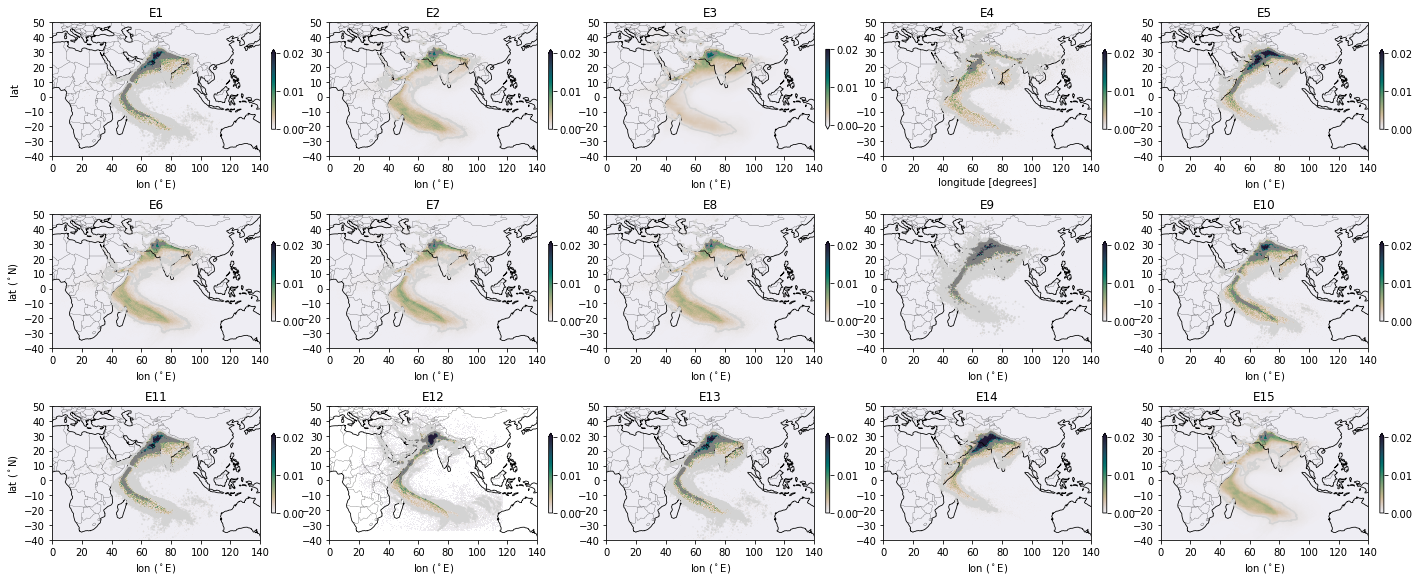

In [15]:
### MAKE PLOT OF DIFFERENT ENSEMBLE MEMBERS (not corrected for different sums) ###
my_projection = crs.PlateCarree(central_longitude=0)

# Make figure
fig = plt.figure(figsize=(24, 10))

#Ensemble member 11:
ax11 = fig.add_subplot(3,5,1, projection=crs.PlateCarree())

srcs_ghent_e3_frac.plot(
        vmin=0,
        vmax=0.02,
        robust=False,
        cmap=cm.rain,
        cbar_kwargs=dict(fraction=0.05, shrink=0.5,label=None),
    )
srcs_ghent_e3_frac.plot.contour(ax=ax11, levels=[0.001, 0.01], colors=["lightgrey", "grey"])
#ax11.set_title("HAMSTER E3", loc="left")
ax11.set_title("E1")
ax11.add_feature(cartopy.feature.COASTLINE, linewidth=0.8)
ax11.add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=.2)

ax11.set_xticks(np.arange(-180, 181, 20), crs=my_projection)
ax11.set_yticks(np.arange(-90, 91, 10), crs=my_projection)
ax11.set_xlim(0, 140)
ax11.set_ylim(-40, 50)
ax11.set_xlabel("lon ($^\circ$E)")
ax11.set_xlabel("lon ($^\circ$E)")

#Ensemble member 6:
ax6 = fig.add_subplot(3,5,2, projection=crs
                      .PlateCarree())

srcs_utrack_e3_frac.plot(
        vmin=0,
        vmax=0.02,
        robust=False,
        cmap=cm.rain,
        cbar_kwargs=dict(fraction=0.05, shrink=0.5,label=None),
    )
srcs_utrack_e3_frac.plot.contour(ax=ax6, levels=[0.001, 0.01], colors=["lightgrey", "grey"])
#ax6.set_title("UTRACK E3", loc="left")
ax6.set_title("E2")
ax6.add_feature(cartopy.feature.COASTLINE, linewidth=0.8)
ax6.add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=.2)

ax6.set_xticks(np.arange(-180, 181, 20), crs=my_projection)
ax6.set_yticks(np.arange(-90, 91, 10), crs=my_projection)
ax6.set_xlim(0, 140)
ax6.set_ylim(-40, 50)
ax6.set_ylabel("")
ax6.set_xlabel("lon ($^\circ$E)")

#Ensemble member 1: WAM2layers
ax = fig.add_subplot(3,5,3, projection=crs.PlateCarree())
srcs_wam2layers_frac.plot(
        vmin=0,
        vmax=0.02,
        robust=False,
        cmap=cm.rain,
        cbar_kwargs=dict(fraction=0.05, shrink=0.5,label=None),
    )
srcs_wam2layers_frac.plot.contour(ax=ax, levels=[0.001, 0.01], colors=["lightgrey", "grey"])
#ax.set_title("WAM2layers", loc="left")
ax.set_title("E3")
ax.add_feature(cartopy.feature.COASTLINE, linewidth=0.8)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=.2)

ax.set_xticks(np.arange(-180, 181, 20), crs=my_projection)
ax.set_yticks(np.arange(-90, 91, 10), crs=my_projection)
ax.set_xlim(0, 140)
ax.set_ylim(-40, 50)
ax.set_ylabel("")
ax.set_xlabel("lon ($^\circ$E)")

#Ensemble member 2:
ax2 = fig.add_subplot(3,5,4, projection=crs.PlateCarree())

srcs_Vigo_e1_Stohl_frac.plot(
        vmin=0,
        vmax=0.02,
        robust=False,
        cmap=cm.rain,
        cbar_kwargs=dict(fraction=0.05, shrink=0.5,label=None),
    )
srcs_Vigo_e1_Stohl_frac.plot.contour(ax=ax2, levels=[0.001, 0.01], colors=["lightgrey", "grey"])
#ax2.set_title("VIGO E1:Stohl", loc="left")
ax2.set_title("E4")
ax2.add_feature(cartopy.feature.COASTLINE, linewidth=0.8)
ax2.add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=.2)

ax2.set_xticks(np.arange(-180, 181, 20), crs=my_projection)
ax2.set_yticks(np.arange(-90, 91, 10), crs=my_projection)
ax2.set_xlim(0, 140)
ax2.set_ylim(-40, 50)
ax2.set_ylabel("")

#Ensemble member 3:
ax3 = fig.add_subplot(3,5,5, projection=crs.PlateCarree())

srcs_Vigo_e2_Sodemann_frac.plot(
        vmin=0,
        vmax=0.02,
        robust=False,
        cmap=cm.rain,
        cbar_kwargs=dict(fraction=0.05, shrink=0.5,label=None),
    )
srcs_Vigo_e2_Sodemann_frac.plot.contour(ax=ax3, levels=[0.001, 0.01], colors=["lightgrey", "grey"])
#ax3.set_title("VIGO E2:Sodemann", loc="left")
ax3.set_title("E5")
ax3.add_feature(cartopy.feature.COASTLINE, linewidth=0.8)
ax3.add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=.2)

ax3.set_xticks(np.arange(-180, 181, 20), crs=my_projection)
ax3.set_yticks(np.arange(-90, 91, 10), crs=my_projection)
ax3.set_xlim(0, 140)
ax3.set_ylim(-40, 50)
ax3.set_ylabel("")
ax3.set_xlabel("lon ($^\circ$E)")

#Ensemble member 5:
ax5 = fig.add_subplot(3,5,6, projection=crs.PlateCarree())

srcs_utrack_e2_frac.plot(
        vmin=0,
        vmax=0.02,
        robust=False,
        cmap=cm.rain,
        cbar_kwargs=dict(fraction=0.05, shrink=0.5,label=None),
    )
srcs_utrack_e2_frac.plot.contour(ax=ax5, levels=[0.001, 0.01], colors=["lightgrey", "grey"])
#ax5.set_title("UTRACK E2", loc="left")
ax5.set_title("E6")
ax5.add_feature(cartopy.feature.COASTLINE, linewidth=0.8)
ax5.add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=.2)

ax5.set_xticks(np.arange(-180, 181, 20), crs=my_projection)
ax5.set_yticks(np.arange(-90, 91, 10), crs=my_projection)
ax5.set_xlim(0, 140)
ax5.set_ylim(-40, 50)
ax5.set_ylabel("lat ($^\circ$N)")
ax5.set_xlabel("lon ($^\circ$E)")

#Ensemble member 4:
ax4 = fig.add_subplot(3,5,7, projection=crs.PlateCarree())

srcs_utrack_e1_frac.plot(
        vmin=0,
        vmax=0.02,
        robust=False,
        cmap=cm.rain,
        cbar_kwargs=dict(fraction=0.05, shrink=0.5,label=None),
    )
srcs_utrack_e1_frac.plot.contour(ax=ax4, levels=[0.001, 0.01], colors=["lightgrey", "grey"])
#ax4.set_title("UTRACK E1", loc="left")
ax4.set_title("E7")
ax4.add_feature(cartopy.feature.COASTLINE, linewidth=0.8)
ax4.add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=.2)

ax4.set_xticks(np.arange(-180, 181, 20), crs=my_projection)
ax4.set_yticks(np.arange(-90, 91, 10), crs=my_projection)
ax4.set_xlim(0, 140)
ax4.set_ylim(-40, 50)
ax4.set_ylabel("")
ax4.set_xlabel("lon ($^\circ$E)")

#Ensemble member 7:
ax8 = fig.add_subplot(3,5,8, projection=crs.PlateCarree())

srcs_utrack_e5_frac.plot(
        vmin=0,
        vmax=0.02,
        robust=False,
        cmap=cm.rain,
        cbar_kwargs=dict(fraction=0.05, shrink=0.5,label=None),
    )
srcs_utrack_e5_frac.plot.contour(ax=ax8, levels=[0.001, 0.01], colors=["lightgrey", "grey"])
#ax8.set_title("UTRACK E5", loc="left")
ax8.set_title("E8")
ax8.add_feature(cartopy.feature.COASTLINE, linewidth=0.8)
ax8.add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=.2)

ax8.set_xticks(np.arange(-180, 181, 20), crs=my_projection)
ax8.set_yticks(np.arange(-90, 91, 10), crs=my_projection)
ax8.set_xlim(0, 140)
ax8.set_ylim(-40, 50)
ax8.set_ylabel("")
ax8.set_xlabel("lon ($^\circ$E)")

#Ensemble member 15:
ax15 = fig.add_subplot(3,5,9, projection=crs.PlateCarree())
srcs_flexpart_xu_frac.plot(
        vmin=0,
        vmax=0.02,
        robust=False,
        cmap=cm.rain,
        cbar_kwargs=dict(fraction=0.05, shrink=0.5,label=None),
    )

srcs_flexpart_xu_frac.plot.contour(ax=ax15, levels=[0.001, 0.01], colors=["lightgrey", "grey"])
#ax15.set_title("FLEXPART-Xu", loc="left")
ax15.set_title("E9")
ax15.add_feature(cartopy.feature.COASTLINE, linewidth=0.8)
ax15.add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=.2)

ax15.set_xticks(np.arange(-180, 181, 20), crs=my_projection)
ax15.set_yticks(np.arange(-90, 91, 10), crs=my_projection)
ax15.set_xlim(0, 140)
ax15.set_ylim(-40, 50)
ax15.set_ylabel("")
ax15.set_xlabel("lon ($^\circ$E)")

#Ensemble member 10:
ax10 = fig.add_subplot(3,5,10, projection=crs.PlateCarree())

srcs_ghent_e2_frac.plot(
        vmin=0,
        vmax=0.02,
        robust=False,
        cmap=cm.rain,
        cbar_kwargs=dict(fraction=0.05, shrink=0.5,label=None),
    )
srcs_ghent_e2_frac.plot.contour(ax=ax10, levels=[0.001, 0.01], colors=["lightgrey", "grey"])
#ax10.set_title("HAMSTER E2", loc="left")
ax10.set_title("E10")
ax10.add_feature(cartopy.feature.COASTLINE, linewidth=0.8)
ax10.add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=.2)

ax10.set_xticks(np.arange(-180, 181, 20), crs=my_projection)
ax10.set_yticks(np.arange(-90, 91, 10), crs=my_projection)
ax10.set_xlim(0, 140)
ax10.set_ylim(-40, 50)
ax10.set_ylabel("")
ax10.set_xlabel("lon ($^\circ$E)")

#Ensemble member 12:
ax12 = fig.add_subplot(3,5,11, projection=crs.PlateCarree())

srcs_ghent_e4_frac.plot(
        vmin=0,
        vmax=0.02,
        robust=False,
        cmap=cm.rain,
        cbar_kwargs=dict(fraction=0.05, shrink=0.5,label=None),
    )
srcs_ghent_e4_frac.plot.contour(ax=ax12, levels=[0.001, 0.01], colors=["lightgrey", "grey"])
#ax12.set_title("HAMSTER E4", loc="left")
ax12.set_title("E11")
ax12.add_feature(cartopy.feature.COASTLINE, linewidth=0.8)
ax12.add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=.2)

ax12.set_xticks(np.arange(-180, 181, 20), crs=my_projection)
ax12.set_yticks(np.arange(-90, 91, 10), crs=my_projection)
ax12.set_xlim(0, 140)
ax12.set_ylim(-40, 50)
ax12.set_ylabel("lat ($^\circ$N)")
ax12.set_xlabel("lon ($^\circ$E)")

#Ensemble member 13:
ax13 = fig.add_subplot(3,5,12, projection=crs.PlateCarree())
srcs_TRACMASS_frac.plot(
        vmin=0,
        vmax=0.02,
        robust=False,
        cmap=cm.rain,
        cbar_kwargs=dict(fraction=0.05, shrink=0.5,label=None),
    )

srcs_TRACMASS_frac.plot.contour(ax=ax13, levels=[0.001, 0.01], colors=["lightgrey", "grey"])
#ax13.set_title("TRACMASS", loc="left")
ax13.set_title("E12")
ax13.add_feature(cartopy.feature.COASTLINE, linewidth=0.8)
ax13.add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=.2)

ax13.set_xticks(np.arange(-180, 181, 20), crs=my_projection)
ax13.set_yticks(np.arange(-90, 91, 10), crs=my_projection)
ax13.set_xlim(0, 140)
ax13.set_ylim(-40, 50)
ax13.set_ylabel("")
ax13.set_xlabel("lon ($^\circ$E)")

#Ensemble member 9:
ax9 = fig.add_subplot(3,5,13, projection=crs.PlateCarree())

srcs_ghent_e1_frac.plot(
        vmin=0,
        vmax=0.02,
        robust=False,
        cmap=cm.rain,
        cbar_kwargs=dict(fraction=0.05, shrink=0.5,label=None),
    )
srcs_ghent_e1_frac.plot.contour(ax=ax9, levels=[0.001, 0.01], colors=["lightgrey", "grey"])
#ax9.set_title("HAMSTER E1", loc="left")
ax9.set_title("E13")
ax9.add_feature(cartopy.feature.COASTLINE, linewidth=0.8)
ax9.add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=.2)

ax9.set_xticks(np.arange(-180, 181, 20), crs=my_projection)
ax9.set_yticks(np.arange(-90, 91, 10), crs=my_projection)
ax9.set_xlim(0, 140)
ax9.set_ylim(-40, 50)
ax9.set_ylabel("")
ax9.set_xlabel("lon ($^\circ$E)")

#Ensemble member 14:
ax14 = fig.add_subplot(3,5,14, projection=crs.PlateCarree())
srcs_flexpart_watersip_frac.plot(
        vmin=0,
        vmax=0.02,
        robust=False,
        cmap=cm.rain,
        cbar_kwargs=dict(fraction=0.05, shrink=0.5,label=None),
    )

srcs_flexpart_watersip_frac.plot.contour(ax=ax14, levels=[0.001, 0.01], colors=["lightgrey", "grey"])
#ax14.set_title("FLEXPART-Watersip", loc="left")
ax14.set_title("E14")
ax14.add_feature(cartopy.feature.COASTLINE, linewidth=0.8)
ax14.add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=.2)

ax14.set_xticks(np.arange(-180, 181, 20), crs=my_projection)
ax14.set_yticks(np.arange(-90, 91, 10), crs=my_projection)
ax14.set_xlim(0, 140)
ax14.set_ylim(-40, 50)
ax14.set_ylabel("")
ax14.set_xlabel("lon ($^\circ$E)")

#Ensemble member 7:
ax7 = fig.add_subplot(3,5,15, projection=crs.PlateCarree())

srcs_utrack_e4_frac.plot(
        vmin=0,
        vmax=0.02,
        robust=False,
        cmap=cm.rain,
        cbar_kwargs=dict(fraction=0.05, shrink=0.5,label=None),
    )
srcs_utrack_e4_frac.plot.contour(ax=ax7, levels=[0.001, 0.01], colors=["lightgrey", "grey"])
#ax7.set_title("UTRACK E4", loc="left")
ax7.set_title("E15")
ax7.add_feature(cartopy.feature.COASTLINE, linewidth=0.8)
ax7.add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=.2)

ax7.set_xticks(np.arange(-180, 181, 20), crs=my_projection)
ax7.set_yticks(np.arange(-90, 91, 10), crs=my_projection)
ax7.set_xlim(0, 140)
ax7.set_ylim(-40, 50)
ax7.set_ylabel("")
ax7.set_xlabel("lon ($^\circ$E)")

fig.savefig("MoistureSources_Fractional_all_random.png",dpi=300)


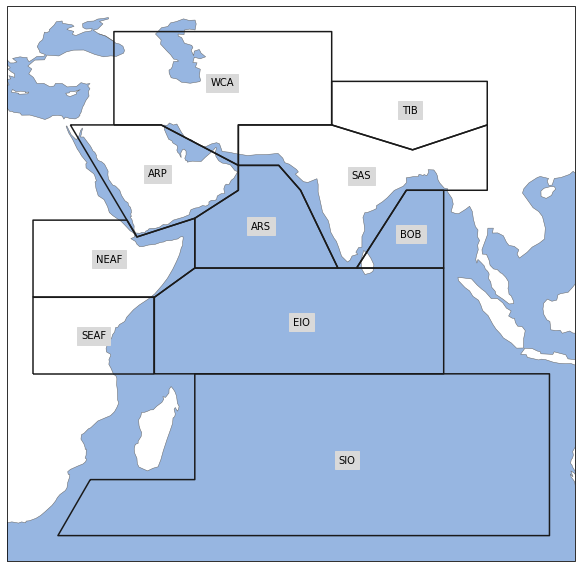

In [19]:
#### Sources per region, import necessary libraries ####
import regionmask
source_regions = xr.open_dataset("IPCCregions_Pakistancase.nc")
source_regions.names

ar6_all = regionmask.defined_regions.ar6.all
selected_regions = ar6_all[['NEAF', 'SEAF', 'WCA', 'TIB', 'ARP', 'SAS', 'ARS', 'BOB', 'EIO',
       'SIO']]

plt.figure(figsize=(12,8))
ax = selected_regions.plot(proj=my_projection, label="abbrev", add_ocean=True)
plt.tight_layout()
plt.savefig("Defined regions.png")

In [20]:
## Calculation fraction (in %) 
mask_3D = selected_regions.mask_3D(srcs_wam2layers_frac,lon_name="longitude",lat_name = "latitude")
weights = np.cos(np.deg2rad(srcs_wam2layers.latitude))
weights = (mask_3D * weights).fillna(0)

srcs_wam2layers_regional = srcs_wam2layers_frac.weighted(weights).sum(dim=("latitude", "longitude"))

# Vigo
mask_3D = selected_regions.mask_3D(srcs_Vigo_e1_Stohl_frac)
weights = np.cos(np.deg2rad(srcs_Vigo_e1_Stohl_frac.lat))
weights = (mask_3D * weights).fillna(0)

srcs_Vigo_e1_Stohl_regional = srcs_Vigo_e1_Stohl_frac.weighted(weights).sum(dim=("lat", "lon"))
srcs_Vigo_e2_Sodemann_regional = srcs_Vigo_e2_Sodemann_frac.weighted(weights).sum(dim=("lat", "lon"))

# Utrack
mask_3D = selected_regions.mask_3D(srcs_utrack_e1_frac)
weights = np.cos(np.deg2rad(srcs_utrack_e1_frac.lat))
weights = (mask_3D * weights).fillna(0)

srcs_utrack_e1_regional = srcs_utrack_e1_frac.weighted(weights).sum(dim=("lat", "lon"))
srcs_utrack_e2_regional = srcs_utrack_e2_frac.weighted(weights).sum(dim=("lat", "lon"))
srcs_utrack_e3_regional = srcs_utrack_e3_frac.weighted(weights).sum(dim=("lat", "lon"))
srcs_utrack_e4_regional = srcs_utrack_e4_frac.weighted(weights).sum(dim=("lat", "lon"))
srcs_utrack_e5_regional = srcs_utrack_e5_frac.weighted(weights).sum(dim=("lat", "lon"))

# Ughent
mask_3D = selected_regions.mask_3D(srcs_ghent_e1_frac)
weights = np.cos(np.deg2rad(srcs_ghent_e1_frac.lat))
weights = (mask_3D * weights).fillna(0)

srcs_ghent_e1_regional = srcs_ghent_e1_frac.weighted(weights).sum(dim=("lat", "lon"))
srcs_ghent_e2_regional = srcs_ghent_e2_frac.weighted(weights).sum(dim=("lat", "lon"))
srcs_ghent_e3_regional = srcs_ghent_e3_frac.weighted(weights).sum(dim=("lat", "lon"))
srcs_ghent_e4_regional = srcs_ghent_e4_frac.weighted(weights).sum(dim=("lat", "lon"))

# Tracmass
mask_3D = selected_regions.mask_3D(srcs_TRACMASS_frac)
weights = np.cos(np.deg2rad(srcs_TRACMASS_frac.lat))
weights = (mask_3D * weights).fillna(0)

srcs_TRACMASS_regional = srcs_TRACMASS_frac.weighted(weights).sum(dim=("lat", "lon"))

# Flexpart Watersip 
mask_3D = selected_regions.mask_3D(srcs_flexpart_watersip_frac)
weights = np.cos(np.deg2rad(srcs_flexpart_watersip_frac.lat))
weights = (mask_3D * weights).fillna(0)

srcs_flexpart_watersip_regional = srcs_flexpart_watersip_frac.weighted(weights).sum(dim=("lat", "lon"))

# Flexpart Ru
mask_3D = selected_regions.mask_3D(srcs_flexpart_xu_frac,lon_name="longitude",lat_name = "latitude")
weights = np.cos(np.deg2rad(srcs_flexpart_xu_frac.latitude))
weights = (mask_3D * weights).fillna(0)

srcs_flexpart_xu_regional = srcs_flexpart_xu_frac.weighted(weights).sum(dim=("latitude", "longitude"))


/usr/local/lib/python3.7/site-packages/regionmask/core/mask.py:169: FutureWarning: Passing 'lon_name' and 'lat_name' is deprecated. Please pass the lon and lat coordinates direcly, e.g., `mask*(ds[lon_name], ds[lat_name])`.
  FutureWarning,
/usr/local/lib/python3.7/site-packages/regionmask/core/mask.py:169: FutureWarning: Passing 'lon_name' and 'lat_name' is deprecated. Please pass the lon and lat coordinates direcly, e.g., `mask*(ds[lon_name], ds[lat_name])`.
  FutureWarning,


In [422]:
#srcs_utrack_e1_test = srcs_utrack_e1.expand_dims(time=["mean"])
print(srcs_utrack_e1_regional.values)
print(srcs_wam2layers_regional.values)

[ 3.5281193   4.16719881  3.9376542   1.76603754  1.35721115 17.05078346
  7.51379499  1.90737185 13.66008531 27.41114784]
[ 4.20710494  3.50558886  4.49482064  1.64587778  2.78387601 24.74760857
 10.49386404  3.16068722  5.81340742 14.21610749]


In [413]:
??selected_regions.mask_3D

Signature:
selected_regions.mask_3D(
    lon_or_obj,
    lat=None,
    *,
    drop=True,
    lon_name=None,
    lat_name=None,
    method=None,
    wrap_lon=None,
    use_cf=None,
)
Docstring:
create a 3D float mask of a set of regions for the given lat/ lon grid

Parameters
----------
lon_or_obj : object or array_like
    Can either be a longitude array and then ``lat`` needs to be
    given. Or an object where the longitude and latitude can be
    retrieved from, either using cf_xarray or by the names "lon"
    and "lat". See also ``use_cf``.
lat : array_like, optional
    If ``lon_or_obj`` is a longitude array, the latitude needs to be
    passed.
drop : boolean, default: True
    If True (default) drops slices where all elements are False (i.e no
    gridpoints are contained in a region). If False returns one slice per
    region.
lon_name : str, optional
    Deprecated. Name of longitude in ``lon_or_obj``, default: "lon".
lat_name : str, optional
    Deprecated. Name of latgitude 

In [426]:
srcs_flexpart_xu

<xarray.DataArray 'variable' (latitude: 721, longitude: 1440)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
  * longitude  (longitude) float64 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * latitude   (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0

In [21]:
srcs_regional_combined = xr.concat([srcs_wam2layers_regional.expand_dims(ensemble=1),
                  srcs_Vigo_e1_Stohl_regional.expand_dims(ensemble=1),
                  srcs_Vigo_e2_Sodemann_regional.expand_dims(ensemble=1),
                  srcs_utrack_e1_regional.expand_dims(ensemble=1),
                  srcs_utrack_e2_regional.expand_dims(ensemble=1),
                  srcs_utrack_e3_regional.expand_dims(ensemble=1),
                  srcs_utrack_e4_regional.expand_dims(ensemble=1),
                  srcs_utrack_e5_regional.expand_dims(ensemble=1),
                  srcs_ghent_e1_regional.expand_dims(ensemble=1),
                  srcs_ghent_e2_regional.expand_dims(ensemble=1),
                  srcs_ghent_e3_regional.expand_dims(ensemble=1),
                  srcs_ghent_e4_regional.expand_dims(ensemble=1),
                  srcs_TRACMASS_regional.expand_dims(ensemble=1),
                  srcs_flexpart_watersip_regional.expand_dims(ensemble=1),
                  srcs_flexpart_xu_regional.expand_dims(ensemble=1),                  
                 ],dim='ensemble')

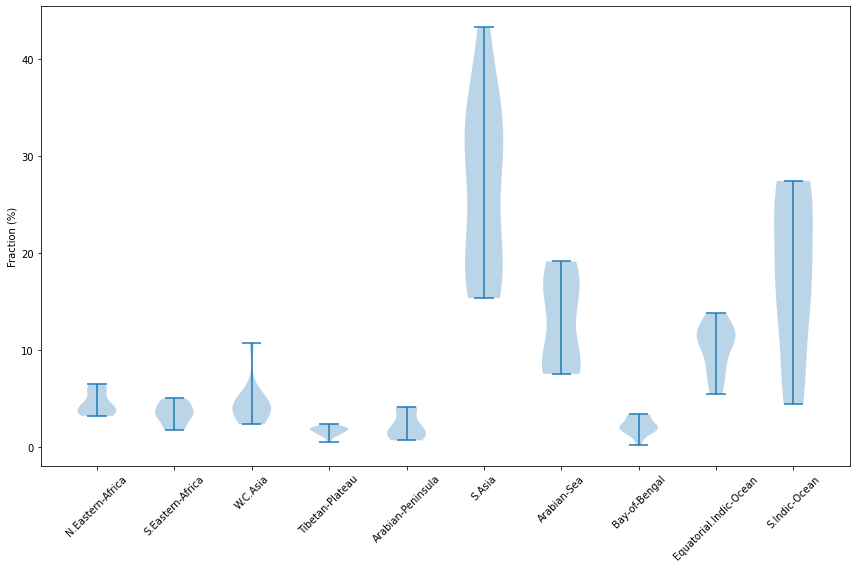

In [23]:
plt.figure(figsize=(12,8))
ax = plt.subplot(111)
plt.violinplot(srcs_regional_combined)
ax.set_xticks(np.arange(1,11))
ax.set_xticklabels(srcs_regional_combined.names.values, rotation=45)
ax.set_ylabel("Fraction (%)")
plt.tight_layout()
plt.savefig("Fraction_per_region.png",dpi=300)